In [722]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib import gridspec
from scipy import stats
import pandas as pd
import scipy.signal as ss
import re
from burst_utils import find_burst, boxcar_kernel
from astropy import modeling
from astropy.modeling import models, fitting
import matplotlib

In [723]:
#Formatting

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [724]:
def sub_npy(npy_fil, subfactor, file_duration, bandwidth, center_frequency):
    
    npy = np.load(npy_fil)
    npy_sub = np.flipud(np.nanmean(npy.reshape(-1, subfactor, npy.shape[1]), axis=1))
    timeseries = npy_sub.sum(0)

    return npy, npy_sub, timeseries

In [725]:
#GMRT A Specs
#subfactor = 16
#file_duration = 163.84 #ms
#bandwidth = 200
#center_frequency = 400

#GBT B Specs

subfactor = 64
bandwidth = 400 #MHz
center_frequency = 800 #MHz
file_duration = 83.33 #ms


#For convenience
bw = float(bandwidth) #MHz
cfreq = float(center_frequency) #MHz

In [726]:
#Load npy
#npy_fil ='scintillation/GMRT_A.dynamicspec_348.8.npy'
npy_fil = 'scintillation/B_686_dm348.8.fits.npy'

In [727]:
npy, npy_sub, timeseries = sub_npy(npy_fil, subfactor, file_duration, bandwidth, center_frequency)
peaks, widths, snrs = find_burst(timeseries)
print(peaks, widths)

3119 128


In [728]:
#Resolutions
tres = file_duration / npy.shape[1]
print('Raw Time Resolution (microsec): ', tres*1e3)
nchan = npy.shape[0]
fres = bw / nchan
print('Raw Frequency Resolution (kHz): ', fres*1e3)

Raw Time Resolution (microsec):  20.34423828125
Raw Frequency Resolution (kHz):  52.083333333333336


In [729]:
#Shape Check
print('GBT_B:', npy.shape)

GBT_B: (7680, 4096)


In [730]:
#Define windowing depending on where burst sits in dynspec
window_left = peaks - 2*widths
window_right = peaks + widths

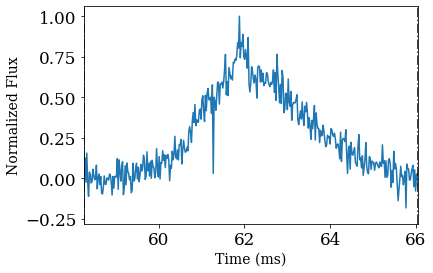

In [731]:
fig = plt.figure()
time = np.linspace(0, len(timeseries), len(timeseries))
timeseries_norm = timeseries/np.max(timeseries)
plt.plot(time*tres, timeseries_norm)
#plt.axvline(peaks, c = 'r', linestyle = 'dotted')
plt.axvline(window_left*tres, c = 'k', linestyle = 'dashdot')
plt.axvline(window_right*tres, c = 'k', linestyle = 'dashdot')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Flux')
plt.xlim(window_left*tres, window_right*tres)
plt.show()

In [732]:
#Crop
time_zoom = np.linspace(0, round(window_right - window_left), round(window_right - window_left))
timeseries_zoom = timeseries_norm[window_left:window_right]

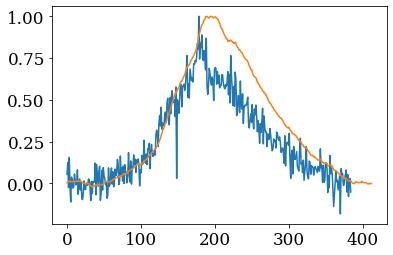

In [733]:
plt.plot(time_zoom, timeseries_zoom)
convolved = ss.convolve(timeseries_zoom, boxcar_kernel(30))
convolved = convolved/np.max(convolved)
plt.plot(convolved/np.max(convolved))

#Find Peaks for Fitting
peaks = ss.find_peaks(convolved)[0]
widths = ss.peak_widths(convolved, peaks)
main_peak = widths[2][np.argmax(widths[0])]

In [734]:
print('Fitter Message: ')
#gauss_exp_init = models.Gaussian1D(0.8, main_peak, 20.)+ models.Gaussian1D(1.2, 220, 40.) + models.Exponential1D(1., -53.)
gauss_exp_init = models.Gaussian1D(0.8, main_peak, 20.) + models.Exponential1D(1., -53.)
fitter = modeling.fitting.LevMarLSQFitter()
gauss_exp_fit = fitter(gauss_exp_init, time_zoom, timeseries_zoom)
print(fitter.fit_info['message'])
print(gauss_exp_fit)

Fitter Message: 
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=0.68045486, mean=194.95743656, stddev=58.5647223)>

    [1]: <Exponential1D(amplitude=-0.02373242, tau=-113.69397338)>
Parameters:
       amplitude_0           mean_0      ...        tau_1       
    ------------------ ----------------- ... -------------------
    0.6804548582330754 194.9574365634968 ... -113.69397338073888


In [735]:
#Peaks
peaks = ss.find_peaks(convolved)[0]

#Peak Widths
widths = ss.peak_widths(convolved, peaks)
width_indices = np.sort(widths[0])[-2:]

#Peak Prominences
prominences = ss.peak_prominences(convolved, peaks)
prom_indices = np.sort(prominences[0])[-2:]

peak_locations = [np.where(prominences[0] == i)[0][0] for i in prom_indices]

print('Peak 1: ', widths[2][peak_locations])

Peak 1:  [398.10654165 143.54384203]


In [736]:
def dr(xdr, slope, b):
            return slope*xdr - b

In [737]:
slope = -2*19.07
b = (-(float(slope))*(twidth)-1080 )

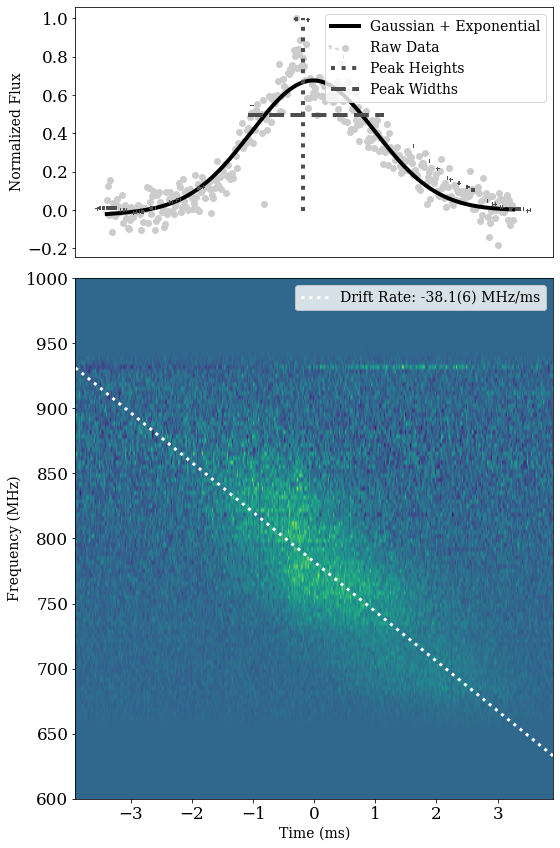

In [738]:
fig = plt.figure(figsize = (8, 12))

grid = fig.add_gridspec(9, 1)

ax1 = fig.add_subplot(grid[0:3, 0])

plt.scatter(time_zoom+10, timeseries_zoom, c = '0.8', label = 'Raw Data')
contour_heights = convolved[peaks] - prominences[0]
plt.vlines(x=peaks, ymin=contour_heights, ymax=convolved[peaks], color = '0.3', zorder = 3, linestyle = 'dotted', linewidth = 4, label = 'Peak Heights')
plt.hlines(*widths[1:], color='0.3', zorder = 4, linestyle = 'dashed', linewidth = 4, label = 'Peak Widths')
plt.plot(time_zoom+10, gauss_exp_fit(time_zoom), linewidth = 4, c = 'black', \
         label = 'Gaussian + Exponential')
         #label = 'Double Gaussian + Exponential')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Normalized Flux')
plt.legend()

ax2 = fig.add_subplot(grid[-6:, 0])

twidth = npy_sub[:, window_left:window_right].shape[1] * tres
time_drift = np.linspace(-twidth/2, twidth/2, npy_sub[:, window_left:window_right].shape[1])
plt.imshow(np.flipud(npy_sub[:, window_left:window_right]), extent = [-twidth/2, twidth/2, 600, 1000], interpolation = None, aspect = 'auto', cmap= 'viridis')
#plt.imshow(npy_sub, interpolation = None, aspect = 'auto')
plt.plot(time_drift, dr(time_drift, slope, b), c = 'w', linestyle = 'dotted', linewidth = 3, label = 'Drift Rate: -38.1(6) MHz/ms')
#plt.plot(time_drift, np.repeat(400, (window_right-window_left)), c = 'w')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')
plt.tight_layout()
plt.legend()

fig.savefig('GBT_B_Drift_Dynspec.png', dpi = 600)

#fig.savefig('MultiComponent_GMRTA_AAS_Plot.png', dpi=600)
plt.show()